In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/oxml-carinoma-classification/img_701568.png
/kaggle/input/oxml-carinoma-classification/img_405863.png
/kaggle/input/oxml-carinoma-classification/img_217481.png
/kaggle/input/oxml-carinoma-classification/img_136044.png
/kaggle/input/oxml-carinoma-classification/img_585360.png
/kaggle/input/oxml-carinoma-classification/img_779156.png
/kaggle/input/oxml-carinoma-classification/img_38771.png
/kaggle/input/oxml-carinoma-classification/img_57613.png
/kaggle/input/oxml-carinoma-classification/img_279108.png
/kaggle/input/oxml-carinoma-classification/img_39157.png
/kaggle/input/oxml-carinoma-classification/img_769175.png
/kaggle/input/oxml-carinoma-classification/img_520490.png
/kaggle/input/oxml-carinoma-classification/img_630916.png
/kaggle/input/oxml-carinoma-classification/img_583497.png
/kaggle/input/oxml-carinoma-classification/img_531231.png
/kaggle/input/oxml-carinoma-classification/img_215078.png
/kaggle/input/oxml-carinoma-classification/img_49868.png
/kaggle/input/oxml

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, Resize
import pandas as pd
from PIL import Image

In [3]:
# Define the path to your dataset and labels CSV file
dataset_path = '/kaggle/input/oxml-carinoma-classification'
labels_file = '/kaggle/input/oxml-carinoma-classification/labels.csv'


# Define the path to save the fine-tuned model
save_path = "/path/output/fine_tuned_model.pth"

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Set the paths
dataset_path = '/kaggle/input/oxml-carinoma-classification'
labels_file = '/kaggle/input/oxml-carinoma-classification/labels.csv'


# Define the custom dataset class

def map_labels(label):
        if label == -1:
            return 0  # Map Carcinoma neg to label 0
        elif label == 0:
            return 1  # Map Carcinoma pos benign to label 1
        elif label == 1:
            return 2  # Map Carcinoma pos malignant to label 2
        else:
            raise ValueError(f"Invalid label: {label}")
        
class CarcinomaDataset(Dataset):
    def __init__(self, dataset_path, labels_file, transform=None):
        self.data = pd.read_csv(labels_file)
        self.dataset_path = dataset_path
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        image_path = f"{self.dataset_path}/img_{img_name}.png"
        image = Image.open(image_path).convert('RGB')
        label = self.data.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        label = map_labels(label)
        
        return image, label
    
    
# Data augmentation transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize image tensors
])

In [5]:
# Create the dataset
dataset = CarcinomaDataset(dataset_path, labels_file, transform=transform)

In [6]:
from torchvision.transforms.functional import to_pil_image

# Accessing an individual item
index = 2  # Index of the item you want to access
image, label = dataset[index]

# Convert the tensor image to PIL Image
pil_image = to_pil_image(image)

print(label)  # Print the label

# Get the size of the image
image_size = pil_image.size
print(image_size)  # Print the image size

2
(224, 224)


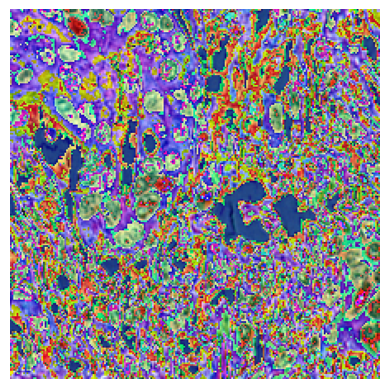

In [7]:
# Convert the tensor image to PIL Image
pil_image = to_pil_image(image)

# Save the image to a file
image_path = "/tmp/temp_image.png"
pil_image.save(image_path)

# Open the image using alternative methods
import matplotlib.pyplot as plt

# Method 1: Using Matplotlib
img = plt.imread(image_path)
plt.imshow(img)
plt.axis("off")
plt.show()

In [8]:
# Split the dataset into train and validation sets
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, stratify=dataset.data['malignant'])

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Load the pre-trained ResNet model
model = resnet50(pretrained=True)

# Modify the last fully connected layer to match the number of classes
num_classes = 3  # Carcinoma neg, Carcinoma pos benign, Carcinoma pos malignant
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
best_f1 = 0

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]


In [9]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Validation
    model.eval()
    val_loss = 0
    val_predictions = []
    val_targets = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs, 1)
            val_predictions.extend(predicted.tolist())
            val_targets.extend(labels.tolist())
    
    val_loss /= len(val_loader.dataset)
    
    # Calculate F1 score
    f1 = f1_score(val_targets, val_predictions, average='weighted')
    
    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | F1 Score: {f1:.4f}")
    
    # Save the best model based on F1 score
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/10 | Train Loss: 0.9755 | Val Loss: 27.5977 | F1 Score: 0.4534
Epoch 2/10 | Train Loss: 1.7577 | Val Loss: 38.5751 | F1 Score: 0.0846
Epoch 3/10 | Train Loss: 1.1802 | Val Loss: 85.9811 | F1 Score: 0.0865
Epoch 4/10 | Train Loss: 0.6787 | Val Loss: 76.6410 | F1 Score: 0.0865
Epoch 5/10 | Train Loss: 0.3850 | Val Loss: 88.6320 | F1 Score: 0.0865
Epoch 6/10 | Train Loss: 0.2472 | Val Loss: 22.9217 | F1 Score: 0.0865
Epoch 7/10 | Train Loss: 0.2430 | Val Loss: 5.9590 | F1 Score: 0.2291
Epoch 8/10 | Train Loss: 0.1431 | Val Loss: 5.6026 | F1 Score: 0.0865
Epoch 9/10 | Train Loss: 0.3738 | Val Loss: 10.9683 | F1 Score: 0.1949
Epoch 10/10 | Train Loss: 0.7073 | Val Loss: 21.9728 | F1 Score: 0.0865


In [10]:
import pandas as pd

# Read the labels.csv file
labels_df = pd.read_csv(labels_file)

# Update the image IDs with prefix and suffix
labels_df['id'] = labels_df['id'].apply(lambda x: f'img_{x}.png')

# Extract all the image IDs
image_ids = labels_df['id'].tolist()

In [11]:
# Define the label reverse mapping function
def reverse_map_labels(label):
    if label == 0:
        return -1  # Reverse map label 0 to Carcinoma neg (-1)
    elif label == 1:
        return 0  # Reverse map label 1 to Carcinoma pos benign (0)
    elif label == 2:
        return 1  # Reverse map label 2 to Carcinoma pos malignant (1)
    else:
        raise ValueError(f"Invalid label: {label}")

In [12]:
import os
import csv
import torch
import torchvision.transforms.functional as TF
import torchvision.models as models

# Load the ResNet-50 model
model = models.resnet50(pretrained=True)

# Replace the fully connected layer with a new one
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # Assuming 3 output classes

# Load the saved state dictionary
model.load_state_dict(torch.load('best_model.pth'))

# Move the model to the device
model.to(device)
model.eval()

# Create a CSV file for the classification results
classification_file = 'classification_results.csv'
with open(classification_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'malignant'])

    # Get the list of image files in the dataset path
    image_files = [file for file in os.listdir(dataset_path) if file.endswith('.png')]

    # Iterate over the image files
    for image_file in image_files:
        # Check if the image ID exists in the labels.csv file
        if image_file in image_ids:
            continue
        
        # Load and preprocess the image
        image_path = os.path.join(dataset_path, image_file)
        image = Image.open(image_path).convert('RGB')
        image = image.resize((224, 224))  # Resize to match the model's input size
        image_tensor = TF.to_tensor(image)
        image_tensor = image_tensor.unsqueeze(0).to(device)

        # Perform the classification
        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            predicted_label = reverse_map_labels(predicted.item())
        image_id = image_file.replace('img_', '').replace('.png', '')
        # Write the classification result to the CSV file
        writer.writerow([image_id, predicted_label])

print("Classification results saved to classification_results.csv")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Classification results saved to classification_results.csv
